In [1]:
import os
from pathlib import Path
import IPython.display as ipd

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import plotly.graph_objs as go
import plotly.offline as py
from IPython import display
import time
from datetime import datetime
import tensorflow as tf
import seaborn as sns
import tensorflow_hub as hub
import subprocess
from subprocess import check_output
%matplotlib inline

tf.logging.set_verbosity(tf.logging.ERROR)

# NOTES
NOTES = "mobilenetv2-128"

# VARS
target_label = "label"
image_key = "imagestring"
id_label = "fname"
OUTSTR = "A{:.4f}_Type{}_LR{}_S{}_B{}{}.csv"
VERBOSE = True
DISPLAY = True # set to False if running as a regular .py script
TEST = True
TPU = False
TARGET_WIDTH = 128
TARGET_HEIGHT = 128
CHANNELS = 3
TYPE = "TL_TPU"
DEFAULT_BS = 128 # default batch size
MODULE = "https://tfhub.dev/google/imagenet/mobilenet_v2_035_128/classification/2"
NUM_SHARDS = 64

if TEST:
    LEARNING_STEPS = 100
    SPP = 50
    LEARNING_RATE = 0.005
    BATCH_SIZE = 64
    VERBOSITY = 1000
    SHUFFLE_SIZE = 64
    TEST_SIZE = 1000
else:
    LEARNING_STEPS = 20000
    SPP = 1000
    LEARNING_RATE = 0.0025
    BATCH_SIZE = 64
    VERBOSITY = 1000
    SHUFFLE_SIZE = 64

LOCALROOT = os.getcwd() + "/"
GCROOT = "gs://ml-piscine/speech/"

ds_str = datetime.strftime(datetime.now(), "%b_%d_%Y_%H_%M_%S")

# PATHS
paths = {
    "Training": GCROOT + "train/",
    "Validation": GCROOT + "validation/",
    "Testing": GCROOT + "test/",
    "Labels": GCROOT + "train/labels.txt",
    "Model": GCROOT + "model_dir/",
    "LocalLogs": LOCALROOT + "logs/{}/".format(ds_str),
    "GCLogs": GCROOT + "logs/{}/".format(ds_str)
}

if not os.path.isdir(paths["LocalLogs"]):
    os.mkdir(paths["LocalLogs"])
    
try:
    os.environ["TPU_NAME"]
except:
    os.environ["TPU_NAME"] = ""

In [2]:
class FLAGS(object):
    use_tpu = TPU
    tpu_name = os.environ["TPU_NAME"]
    model_dir = paths["Model"]
    iterations = SPP
    num_shards = NUM_SHARDS

In [3]:
def sec_to_str(secs):
    ms = secs - int(secs)
    days = int(secs // (24 * 3600))
    hours = int((secs % ((24 * 3600))) // 3600)
    minutes = int((secs % 3600) // 60)
    seconds = int(secs % 60)
    return "{:02}:{:02}:{:02}:{:02}.{}".format(days, hours, minutes, seconds, "{:.3}".format(ms)[2:])

def timer(f, *args):
    print("Start: {}".format(datetime.now()))
    start = time.time()
    result = f(*args)
    end = time.time()
    print("End: {}".format(datetime.now()))
    print("Finished in {}".format(sec_to_str(end - start)))
    return result

def send_to_bucket(path_to_file, path_to_bucket):
    command = ["gsutil", "cp", "-r", path_to_file, path_to_bucket]
    subprocess.run(command)

In [4]:
def parse_label(tsr, sess):
    return sess.run(tsr)

def make_dataframe_from_tfrecords(records):
    IMAGES, LABELS = [], []
    count = 0
    for record in records:
        for file in tf.python_io.tf_record_iterator(record):
            count += 1
            if count % VERBOSITY == 0:
                print("\tRead in {}th record".format(count))
            features = (
                tf.parse_single_example(
                    file,
                    features={
                        'image/encoded': tf.FixedLenFeature([], tf.string),
                        'image/class/label': tf.FixedLenFeature([], tf.int64),
                        'image/filename': tf.FixedLenFeature([], tf.string)
                    }
                )
            )
            label = tf.cast(features['image/class/label'], tf.int32)
            image = tf.image.decode_png(features['image/encoded'], channels=3)
            image = tf.image.convert_image_dtype(image, tf.float32)
            image = tf.reshape(image, [128, 128, 3])         
            IMAGES.append(image)
            LABELS.append(label)
    df = pd.DataFrame({target_label:LABELS, image_key:IMAGES})
    return df


In [5]:
count = 0
def _parse_function(file):
    global count
    count += 1
    if count % VERBOSITY == 0:
        print("\tProcessed {}th image".format(count))
    expected_shape = tf.constant([TARGET_HEIGHT, TARGET_WIDTH, CHANNELS])
    features = (
        tf.parse_single_example(
            file,
            features={
                'image/encoded': tf.FixedLenFeature([], tf.string),
                'image/class/label': tf.FixedLenFeature([], tf.int64)
            }
        )
    )
    label = tf.cast(features['image/class/label'], tf.int32)
    image = tf.image.decode_png(features['image/encoded'], channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.reshape(image, expected_shape) 
    
    return image, label

In [6]:
def mobilenet_model_fn(features, labels, mode):
    # Load mobilenet-v2 model.
    global num_label
    module = hub.Module(MODULE)
    features = tf.squeeze(features)
    outputs = module(features)

    logits = tf.layers.dense(inputs=outputs, units=num_labels)

    predictions = {
        "classes": tf.argmax(input=logits, axis=1),
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    if not FLAGS.use_tpu:
        tf.summary.histogram("predictions", predictions["probabilities"])
        tf.summary.histogram("classes", predictions["classes"])

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    predictions["loss"] = loss

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE)
        if FLAGS.use_tpu:
            optimizer = tf.contrib.tpu.CrossShardOptimizer(optimizer)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [7]:
def create_training_input_fn(dataset, batch_size, num_epochs=None):
    def _input_fn(num_epochs=None, shuffle=True):
        ds = dataset.map(_parse_function)
        ds = ds.batch(batch_size).repeat(num_epochs)
        if shuffle:
            ds = ds.shuffle(SHUFFLE_SIZE)
        feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
        return feature_batch, label_batch
    return _input_fn

def create_predict_input_fn(dataset, batch_size):
    def _input_fn():
        ds = dataset.map(_parse_function)
        ds = ds.batch(batch_size)
        feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
        return feature_batch, label_batch
    return _input_fn

def train():
    periods = LEARNING_STEPS // SPP
    steps_per_period = LEARNING_STEPS // periods
    t_accs = []
    v_accs = []
    t_lls = []
    v_lls = []
    print("Training model...\nMetrics:")
    print("\tPERIOD\tTYPE\tTRAIN.\tVALID.")
    for period in range(periods):
        classifier.train(
            input_fn=train_input_fn,
            steps=steps_per_period)
        training_stats = classifier.evaluate(input_fn=training_eval_input_fn)
        validation_stats = classifier.evaluate(input_fn=validation_eval_input_fn)
        t_ll = training_stats["loss"]
        t_acc = 100 * training_stats["accuracy"]
        v_ll = validation_stats["loss"]
        v_acc = 100 * validation_stats["accuracy"]
        print("\t{}\tLgLs\t{:.2f}\t{:.2f}".format(period, t_ll, v_ll))
        print("\t\tAcc.\t{:.2f}%\t{:.2f}%\n".format(t_acc, v_acc))
        t_lls.append(t_ll);
        v_lls.append(v_ll)
        t_accs.append(t_acc)
        v_accs.append(v_acc)
    accuracy = classifier.evaluate(input_fn=validation_eval_input_fn)["accuracy"] * 100
    return classifier, accuracy, t_lls, v_lls, t_accs, v_accs

In [8]:
if FLAGS.use_tpu:
    my_project_name = subprocess.check_output(['gcloud','config','get-value','project'])
    my_zone = subprocess.check_output(['gcloud','config','get-value','compute/zone'])
    cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(
            tpu_names=[FLAGS.tpu_name],
            zone=my_zone,
            project=my_project)
    master = tpu_cluster_resolver.get_master()
else:
    master = ''

In [9]:
# Read in TFRecords
train_records = ["speech_train_{:05}-of-{:05}.tfrecord".format(i, FLAGS.num_shards) for i in range(FLAGS.num_shards)]
train_records = list(map(lambda x: paths["Training"] + x, train_records))
validation_records = ["speech_validation_{:05}-of-{:05}.tfrecord".format(i, FLAGS.num_shards) for i in range(FLAGS.num_shards)]
validation_records = list(map(lambda x: paths["Validation"] + x, validation_records))
test_records = ["test_{:05}-of-{:05}.tfrecord".format(i, FLAGS.num_shards) for i in range(FLAGS.num_shards)]
test_records = list(map(lambda x: paths["Testing"] + x, test_records))

In [10]:
if VERBOSE:
    print("Training Records:")
    _ = [print("\t", record) for record in train_records]

Training Records:
	 gs://ml-piscine/speech/train/speech_train_00000-of-00064.tfrecord
	 gs://ml-piscine/speech/train/speech_train_00001-of-00064.tfrecord
	 gs://ml-piscine/speech/train/speech_train_00002-of-00064.tfrecord
	 gs://ml-piscine/speech/train/speech_train_00003-of-00064.tfrecord
	 gs://ml-piscine/speech/train/speech_train_00004-of-00064.tfrecord
	 gs://ml-piscine/speech/train/speech_train_00005-of-00064.tfrecord
	 gs://ml-piscine/speech/train/speech_train_00006-of-00064.tfrecord
	 gs://ml-piscine/speech/train/speech_train_00007-of-00064.tfrecord
	 gs://ml-piscine/speech/train/speech_train_00008-of-00064.tfrecord
	 gs://ml-piscine/speech/train/speech_train_00009-of-00064.tfrecord
	 gs://ml-piscine/speech/train/speech_train_00010-of-00064.tfrecord
	 gs://ml-piscine/speech/train/speech_train_00011-of-00064.tfrecord
	 gs://ml-piscine/speech/train/speech_train_00012-of-00064.tfrecord
	 gs://ml-piscine/speech/train/speech_train_00013-of-00064.tfrecord
	 gs://ml-piscine/speech/train

In [11]:
if VERBOSE:
    print("Validation Records:")
    _ = [print("\t", record) for record in validation_records]

Validation Records:
	 gs://ml-piscine/speech/validation/speech_validation_00000-of-00064.tfrecord
	 gs://ml-piscine/speech/validation/speech_validation_00001-of-00064.tfrecord
	 gs://ml-piscine/speech/validation/speech_validation_00002-of-00064.tfrecord
	 gs://ml-piscine/speech/validation/speech_validation_00003-of-00064.tfrecord
	 gs://ml-piscine/speech/validation/speech_validation_00004-of-00064.tfrecord
	 gs://ml-piscine/speech/validation/speech_validation_00005-of-00064.tfrecord
	 gs://ml-piscine/speech/validation/speech_validation_00006-of-00064.tfrecord
	 gs://ml-piscine/speech/validation/speech_validation_00007-of-00064.tfrecord
	 gs://ml-piscine/speech/validation/speech_validation_00008-of-00064.tfrecord
	 gs://ml-piscine/speech/validation/speech_validation_00009-of-00064.tfrecord
	 gs://ml-piscine/speech/validation/speech_validation_00010-of-00064.tfrecord
	 gs://ml-piscine/speech/validation/speech_validation_00011-of-00064.tfrecord
	 gs://ml-piscine/speech/validation/speech_v

In [12]:
if VERBOSE:
    print("Testing Records:")
    _ = [print("\t", record) for record in test_records]

Testing Records:
	 gs://ml-piscine/speech/test/test_00000-of-00064.tfrecord
	 gs://ml-piscine/speech/test/test_00001-of-00064.tfrecord
	 gs://ml-piscine/speech/test/test_00002-of-00064.tfrecord
	 gs://ml-piscine/speech/test/test_00003-of-00064.tfrecord
	 gs://ml-piscine/speech/test/test_00004-of-00064.tfrecord
	 gs://ml-piscine/speech/test/test_00005-of-00064.tfrecord
	 gs://ml-piscine/speech/test/test_00006-of-00064.tfrecord
	 gs://ml-piscine/speech/test/test_00007-of-00064.tfrecord
	 gs://ml-piscine/speech/test/test_00008-of-00064.tfrecord
	 gs://ml-piscine/speech/test/test_00009-of-00064.tfrecord
	 gs://ml-piscine/speech/test/test_00010-of-00064.tfrecord
	 gs://ml-piscine/speech/test/test_00011-of-00064.tfrecord
	 gs://ml-piscine/speech/test/test_00012-of-00064.tfrecord
	 gs://ml-piscine/speech/test/test_00013-of-00064.tfrecord
	 gs://ml-piscine/speech/test/test_00014-of-00064.tfrecord
	 gs://ml-piscine/speech/test/test_00015-of-00064.tfrecord
	 gs://ml-piscine/speech/test/test_0001

In [28]:
# Read the labels mapping for the TFRecords into a dict for lookup
command = ["gsutil", "cp", paths["Training"] + "labels.txt", "labels.txt"]
subprocess.run(command)
path = "labels.txt"
with open(path, 'r') as f:
    labels = {pair[1].strip() : int(pair[0]) for pair in [line.split(":") for line in f.readlines()]}
num_labels = len(labels)
labels_ = {labels[k]:k for k in labels}
print(labels, "\n")
print(labels_)

{'bed': 0, 'no': 14, 'down': 4, 'one': 17, 'house': 10, 'silence': 21, 'right': 18, 'happy': 9, 'six': 22, 'three': 24, 'marvin': 12, 'off': 15, 'on': 16, 'two': 26, 'cat': 2, 'left': 11, 'yes': 29, 'dog': 3, 'eight': 5, 'wow': 28, 'bird': 1, 'four': 7, 'stop': 23, 'up': 27, 'seven': 19, 'go': 8, 'tree': 25, 'sheila': 20, 'nine': 13, 'zero': 30, 'five': 6} 

{0: 'bed', 1: 'bird', 2: 'cat', 3: 'dog', 4: 'down', 5: 'eight', 6: 'five', 7: 'four', 8: 'go', 9: 'happy', 10: 'house', 11: 'left', 12: 'marvin', 13: 'nine', 14: 'no', 15: 'off', 16: 'on', 17: 'one', 18: 'right', 19: 'seven', 20: 'sheila', 21: 'silence', 22: 'six', 23: 'stop', 24: 'three', 25: 'tree', 26: 'two', 27: 'up', 28: 'wow', 29: 'yes', 30: 'zero'}


In [14]:
# Reverse the labels dictionary to re-map numbers to their original string labels 
# Place all the unwanted labels into an unknown category in the reverse lookup dict
allowed_labels = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "silence"]
reverse_lookup = {labels[label]:("unknown" if label not in allowed_labels else label) for label in labels}        
print(reverse_lookup)

{0: 'unknown', 1: 'unknown', 2: 'unknown', 3: 'unknown', 4: 'down', 5: 'unknown', 6: 'unknown', 7: 'unknown', 8: 'go', 9: 'unknown', 10: 'unknown', 11: 'left', 12: 'unknown', 13: 'unknown', 14: 'no', 15: 'off', 16: 'on', 17: 'unknown', 18: 'right', 19: 'unknown', 20: 'unknown', 21: 'silence', 22: 'unknown', 23: 'stop', 24: 'unknown', 25: 'unknown', 26: 'unknown', 27: 'up', 28: 'unknown', 29: 'yes', 30: 'unknown'}


In [15]:
# Read in the test set filenames for later output
labels = dict()
command = ["gsutil", "cp", paths["Testing"]+"filenames.txt", "filenames.txt"]
subprocess.run(command)
path = "filenames.txt"
with open(path, 'r') as file:
    f = lambda x: pd.Series([line.strip() for line in x.readlines()])
    ids = timer(f, file)

if VERBOSE:
    print("IDS")
    print(ids.describe())
    print(ids.head(10))

Start: 2018-07-18 20:57:25.957621
End: 2018-07-18 20:57:26.012267
Finished in 00:00:00:00.0545
IDS
count                 158538
unique                158538
top       clip_54d3d0687.wav
freq                       1
dtype: object
0    clip_acdd680e6.wav
1    clip_7f3e8aadd.wav
2    clip_d63745704.wav
3    clip_3ee75e2ec.wav
4    clip_a2e1a87ad.wav
5    clip_b7f6cfdee.wav
6    clip_521c0fe6c.wav
7    clip_3526fb428.wav
8    clip_002716f99.wav
9    clip_b01a21a25.wav
dtype: object


In [16]:
# Make datasets from tfrecords
train_data = tf.data.TFRecordDataset((train_records))
validation_data = tf.data.TFRecordDataset((validation_records))
test_data = tf.data.TFRecordDataset((test_records))

In [17]:
print("TRAINING")
print(train_data)
print(type(train_data))
print("VALIDATION")
print(validation_data)
print(type(validation_data))
print("TESTING")
print(test_data)
print(type(test_data))

TRAINING
<TFRecordDataset shapes: (), types: tf.string>
<class 'tensorflow.python.data.ops.readers.TFRecordDataset'>
VALIDATION
<TFRecordDataset shapes: (), types: tf.string>
<class 'tensorflow.python.data.ops.readers.TFRecordDataset'>
TESTING
<TFRecordDataset shapes: (), types: tf.string>
<class 'tensorflow.python.data.ops.readers.TFRecordDataset'>


In [18]:
# Configure the TPU
my_tpu_run_config = tf.contrib.tpu.RunConfig(
    master=master,
    evaluation_master=master,
    model_dir=FLAGS.model_dir,
    session_config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True),
    tpu_config=tf.contrib.tpu.TPUConfig(FLAGS.iterations, FLAGS.num_shards),
)

# Create the Estimator
if FLAGS.use_tpu:
    classifier = tf.contrib.tpu.TPUEstimator(
        model_fn=mobilenet_model_fn,
        config=my_tpu_run_config,
        use_tpu=FLAGS.use_tpu)
else:
    classifier = tf.estimator.Estimator(model_fn=mobilenet_model_fn, model_dir=paths["Model"])

In [19]:
# Create the input functions.
eval_params = {'batch-size':DEFAULT_BS}
train_params = {'batch-size':BATCH_SIZE}
training_eval_input_fn = create_predict_input_fn(train_data, DEFAULT_BS)
validation_eval_input_fn = create_predict_input_fn(validation_data, DEFAULT_BS)
train_input_fn = create_training_input_fn(train_data, BATCH_SIZE)

In [20]:
# Train
classifier, accuracy, t_lls, v_lls, t_accs, v_accs = timer(train)

Start: 2018-07-18 20:57:31.454353
Training model...
Metrics:
	PERIOD	TYPE	TRAIN.	VALID.
	0	LgLs	2.53	2.48
		Acc.	28.78%	29.76%

	1	LgLs	2.38	2.34
		Acc.	32.99%	33.71%

End: 2018-07-18 21:11:44.608299
Finished in 00:00:14:13.154


Final accuracy (on validation data): 33.7119%


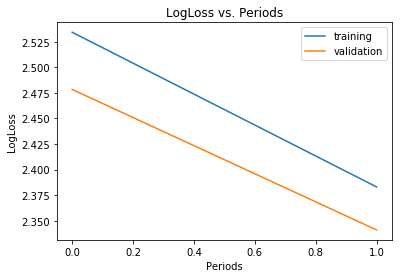

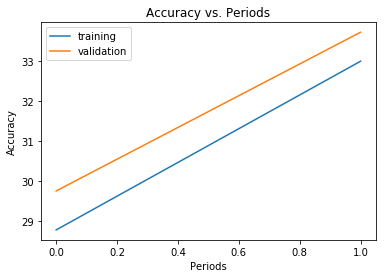

In [21]:
print("Final accuracy (on validation data): {:.4f}%".format(accuracy))

# Output a graph of loss metrics over periods.
if DISPLAY:
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.plot(t_lls, label="training")
    plt.plot(v_lls, label="validation")
    plt.legend()
    plt.show()
    plt.savefig(paths["LocalLogs"] + "loss.jpg")
    send_to_bucket(paths["LocalLogs"] + "loss.jpg", paths["GCLogs"] + "loss.jpg")

# Output a graph of accuracy over periods.
if DISPLAY:
    plt.ylabel("Accuracy")
    plt.xlabel("Periods")
    plt.title("Accuracy vs. Periods")
    plt.plot(t_accs, label="training")
    plt.plot(v_accs, label="validation")
    plt.legend()
    plt.show()
    plt.savefig(paths["LocalLogs"] + "accuracy.jpg")
    send_to_bucket(paths["LocalLogs"] + "accuracy.jpg", paths["GCLogs"] + "accuracy.jpg")

In [24]:
# Make Predictions
test_input_fn = create_predict_input_fn(test_data, DEFAULT_BS)
f = lambda: np.array([item['classes'] for item in classifier.predict(input_fn=test_input_fn)])
predictions = timer(f)
predictions = [reverse_lookup[x] for x in predictions]

Start: 2018-07-18 21:15:02.003881
End: 2018-07-18 21:41:26.339855
Finished in 00:00:26:24.336


In [25]:
# Make the output Dataframe
output = pd.DataFrame({id_label:ids, target_label:predictions})
print(output)

                     fname    label
0       clip_acdd680e6.wav     stop
1       clip_7f3e8aadd.wav     stop
2       clip_d63745704.wav    right
3       clip_3ee75e2ec.wav       go
4       clip_a2e1a87ad.wav     stop
5       clip_b7f6cfdee.wav      yes
6       clip_521c0fe6c.wav  silence
7       clip_3526fb428.wav       on
8       clip_002716f99.wav       on
9       clip_b01a21a25.wav       up
10      clip_1423b5ae9.wav       up
11      clip_2df4aadd0.wav     down
12      clip_7603fed12.wav    right
13      clip_fe6b09280.wav     left
14      clip_10c15caea.wav      off
15      clip_0cb7dcd9c.wav     down
16      clip_2567b3e73.wav       up
17      clip_65d147a85.wav       up
18      clip_67bdbb49e.wav    right
19      clip_2d03c2dbf.wav       on
20      clip_e3fbbdf03.wav  silence
21      clip_52858da24.wav     stop
22      clip_a62953cd1.wav     left
23      clip_d1fdb62eb.wav       on
24      clip_076b2daff.wav      yes
25      clip_c342cb1e9.wav     down
26      clip_4e9384d68.wav  

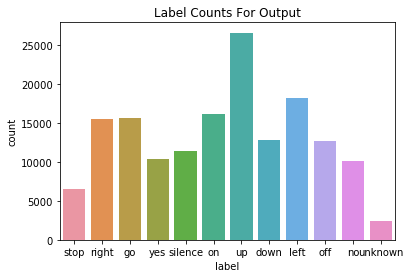

In [26]:
if DISPLAY:
    ax = sns.countplot(x=target_label, data=output)
    ax.set_title("Label Counts For Output")
    ax.get_figure().savefig(paths["LocalLogs"] + "output_counts.jpg")
    send_to_bucket(paths["LocalLogs"] + "output_counts.jpg", paths["GCLogs"] + "output_counts.jpg")

In [27]:
name = OUTSTR.format(accuracy, TYPE, LEARNING_RATE, LEARNING_STEPS, BATCH_SIZE,"_" + NOTES if NOTES else "")
print("Filename: '{}'".format(name))
if not TEST:
    output.to_csv(name, index=False)
    print("Saved to './{}'".format(name))
    send_to_bucket(name, GCROOT + name)

Filename: 'A33.7119_TypeTL_TPU_LR0.005_S100_B64_mobilenetv2-128.csv'
